In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
import scipy.stats

%matplotlib inline

# load data

In [2]:
start = '2016-08-07 00:00:00'
end = '2016-09-22 00:00:00'

def filter_by_time(df):
    time = (df.datetime > start) & (df.datetime < end)
    return df[time]

In [3]:
# load airpublic data

def clean(df):
    df['datetime'] = pd.to_datetime(df.timestamp)
    df['timestamp'] = pd.to_datetime(df.timestamp)    
    
    df = df.sort_values(by='datetime')
    
    sane_gps = (df.latitude > 0) & (df.gps_fix == 1)
    # Marylebeone site has code MY1 and these GPS coords
    my1_site = (df.longitude > -0.155) & (df.longitude <  -0.154) & (df.latitude > 51.52) &  (df.latitude < 51.53 )
    cleaned_df = df[sane_gps & my1_site]
    count_clean = len(cleaned_df)
    count_all = len(df)
    print('Removed %s rows' % (count_all - count_clean))
    print('Remaining %s rows' % (count_clean))
    
    # Warning: the computer timezone must be gmt in order to match kings
    # assuming only one sensor
    cleaned_df = cleaned_df.set_index('datetime')  
    
    return cleaned_df

In [4]:
df_airpublic = pd.read_csv('airpublic_sensor.csv')
df_airpublic = clean(df_airpublic)
ds = xr.Dataset.from_dataframe(df_airpublic)
ds_mean = ds.resample(freq='1H', dim='datetime', how='mean', skipna=True)

Removed 4679 rows
Remaining 37247 rows


In [5]:
# load kings

df_kings = pd.read_csv('kings_sensor.csv')

def prep_kings(df_kings):
    df_kings['datetime'] = pd.to_datetime(df_kings.date)    
    df_kings = filter_by_time(df_kings)    
    df_kings = df_kings.set_index('datetime')    
    ds_kings = xr.Dataset.from_dataframe(df_kings)
    return ds_kings

ds_kings = prep_kings(df_kings)

In [6]:
ds_merged = xr.merge([ds_kings[['pm10', 'pm10_raw']].rename({'pm10': 'kings_vol_pm10', 'pm10_raw': 'kings_vol_pm10_raw'}), ds_mean], join='inner')

In [7]:
def compare(ds_merged, airpublic_measure, kings_measure):
    ds_merged_one = ds_merged[[airpublic_measure, kings_measure]]
    # ds_merged_one['error'] = ds_merged_one[kings_measure] - ds_merged[airpublic_measure]
    # ds_merged_one.sel(datetime=example_date).to_dataframe().plot()
    ds_merged_one.to_dataframe().plot()
    sns.pairplot(ds_merged_one.to_dataframe().dropna().reset_index(), vars=ds_merged_one.data_vars)
    print(ds_merged_one.to_dataframe().describe())
    # calculate r2 score
    r2 = r2_score(ds_merged_one.to_dataframe().dropna()[airpublic_measure],
                  ds_merged_one.to_dataframe().dropna()[kings_measure])
    print("r2 score: ", r2)

    # KS-test
    ks_statistic, p_value = scipy.stats.ks_2samp(ds_merged_one.to_dataframe().dropna()[airpublic_measure],
                                                 ds_merged_one.to_dataframe().dropna()[kings_measure])
    print("Probability that they belong to the same distribution (KS p-value): ", p_value)

In [8]:
# convenience function for reshaping for use in sklearn linear regression
def reshape(xarray_col):
    return xarray_col.values.reshape((len(xarray_col.values), 1))

def chronological_split(df_xcol, df_ycol, test_size=0.2):
    assert len(df_xcol) == len(df_ycol)
    test_number = int(test_size * len(df_xcol))
    train_number = len(df_xcol) - test_number
    return df_xcol.head(train_number), df_xcol.tail(test_number), df_ycol.head(train_number), df_ycol.tail(test_number)

def linear_regr_fudge(ds_merged, airpublic_measure, kings_measure, test_size=0.1, split='random'):
    if split not in ['random', 'chronological']:
        raise ValueError("splitting method should either be random or chronological")
    df_merged_temp = ds_merged.to_dataframe().dropna(subset=[kings_measure, airpublic_measure])
    if split == 'random':
        kings_train, kings_test, ap_train, ap_test = \
            train_test_split(df_merged_temp[kings_measure], df_merged_temp[airpublic_measure], test_size=test_size)
    else:
        kings_train, kings_test, ap_train, ap_test = \
            chronological_split(df_merged_temp[kings_measure], df_merged_temp[airpublic_measure], test_size=test_size)

    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(reshape(ap_train), reshape(kings_train))
    # The coefficients
    print('Coefficients: \n', regr.coef_, regr.intercept_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(reshape(ap_test)) - reshape(kings_test)) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(reshape(ap_test), reshape(kings_test)))
    scores = cross_val_score(regr, reshape(ap_test), reshape(kings_test), scoring='r2')
    print("R2 score: %.3f" % scores[0])

    plt.scatter(ap_test, kings_test, color='black')
    plt.scatter(ap_train, kings_train, color='red')
    plt.plot(reshape(ap_train), regr.predict(reshape(ap_train)), color='blue',
             linewidth=1)
    plt.show()
    return regr.coef_, regr.intercept_

# pm 10

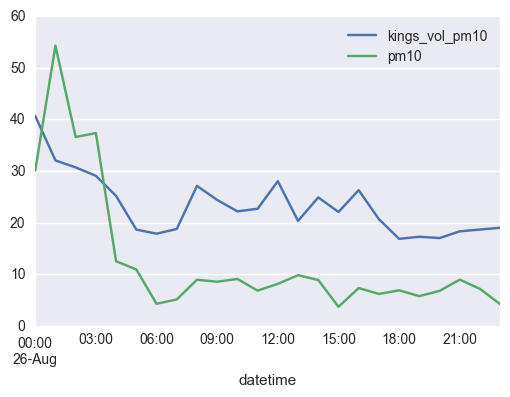

In [9]:
ds_merged_pm10 = ds_merged[['kings_vol_pm10','pm10']]
ds_merged_pm10.sel(datetime='2016-08-26').to_dataframe().plot()

Coefficients: 
 [[ 0.35232088]] [ 22.46056941]
Mean squared error: 87.32
Variance score: 0.01
R2 score: 0.038


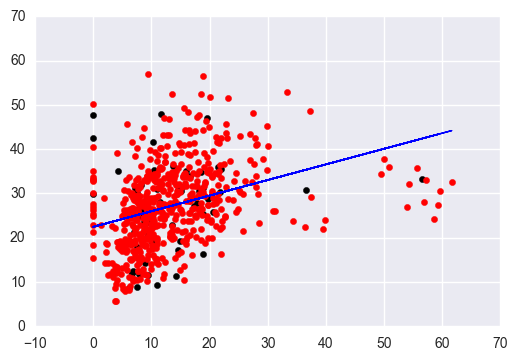

In [10]:
m, c = linear_regr_fudge(ds_merged, 'pm10', 'kings_vol_pm10', test_size=0.1, split='random')

            pm10  pm10_modified
count  24.000000      24.000000
mean   12.886713      27.000827
std    12.925249       4.553835
min     3.744909      23.779979
25%     6.672827      24.811546
50%     8.388132      25.415883
75%    10.140239      26.033187
max    54.283548      41.585797
r2 score:  -0.663753129917
Probability that they belong to the same distribution (KS p-value):  2.5984625573e-08


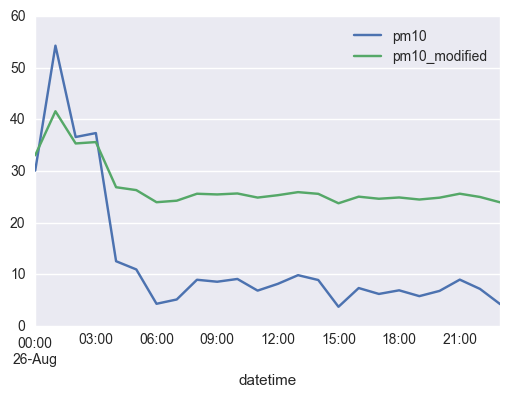

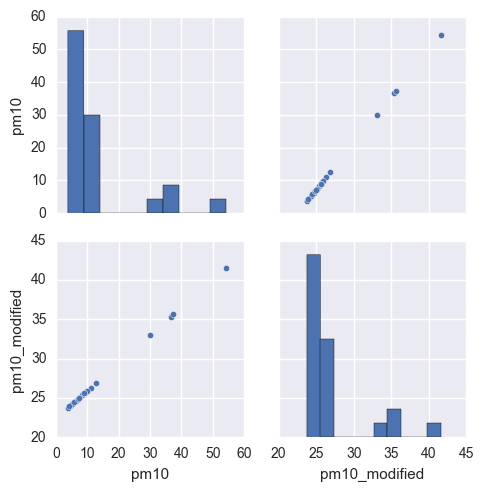

In [11]:
# plot the result
ds_merged['pm10_modified'] = ds_merged['pm10'] * m[0][0] + c[0]
compare(ds_merged.sel(datetime='2016-08-26'),'pm10','pm10_modified')

Coefficients: 
 [[ 0.32770507]] [ 21.88188477]
Mean squared error: 160.00
Variance score: -0.60
R2 score: -0.970


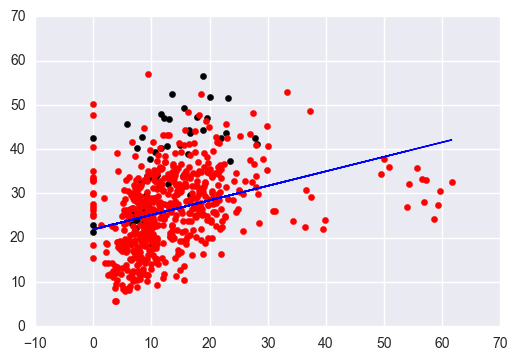

In [12]:
m, c = linear_regr_fudge(ds_merged, 'pm10', 'kings_vol_pm10', test_size=0.1, split='chronological')

            pm10  pm10_modified
count  24.000000      24.000000
mean   12.886713      26.104926
std    12.925249       4.235670
min     3.744909      23.109110
25%     6.672827      24.068604
50%     8.388132      24.630718
75%    10.140239      25.204893
max    54.283548      39.670879
r2 score:  -0.543297832677
Probability that they belong to the same distribution (KS p-value):  2.5984625573e-08


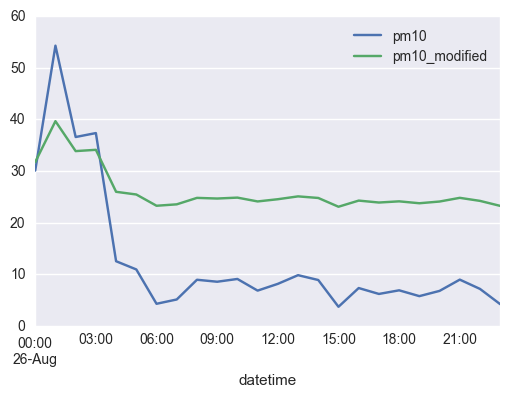

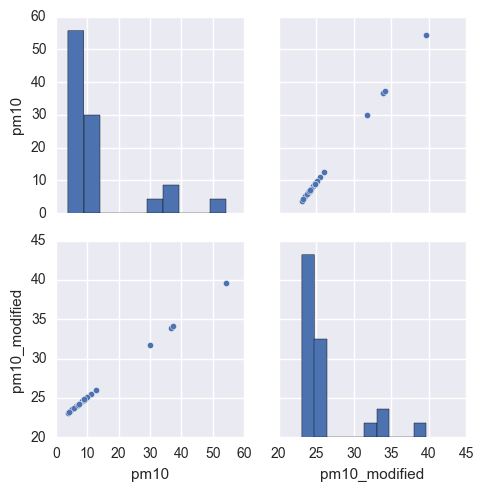

In [13]:
# plot the result
ds_merged['pm10_modified'] = ds_merged['pm10'] * m[0][0] + c[0]
compare(ds_merged.sel(datetime='2016-08-26'),'pm10','pm10_modified')